In [49]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, f1_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

In [50]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats

In [51]:
save_plots = False
random_seed_state = 42
classify_bedrock_only = False
pickle_model = False
pickle_model_name = 'grouped'
pickle_file_path = '../../../model'


### if only bedrock sites are classified then classes are label encoded, if bedrock sites alone are not being classified then the class sites would have already been label encoded in the 1 data_preproccessing notebook 

In [52]:
if classify_bedrock_only:
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']

### The class column is stored as the variable y 

In [53]:
y_train = np.array(train_data_formodel['class'])

### The variables identified as best by the 2 feature_selection notebook are used as features

In [54]:
train_data_feats = train_data_formodel[best_feats]

In [55]:
x_train = np.array(train_data_feats)

In [56]:
my_scaler = StandardScaler()

In [57]:


x_test = np.array(test_data[best_feats])

In [58]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(1158, 31)
(363, 31)
(1158,)


In [59]:
# Some useful parameters which will come in handy later on
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None, set_seed = True):

        if set_seed:
            params['random_state'] = seed

            
        self.clf = clf(**params)
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [60]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [61]:
def get_oof_xgboost(x_train, y_train, x_test):
    esti = xgb.XGBClassifier(booster="gbtree", max_depth = 5, min_child_weight=3, n_estimators=5000)
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        esti.fit(x_tr, y_tr)

        oof_train[test_index] = esti.predict(x_te)
        oof_test_skf[i, :] = esti.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [62]:

rf_params = {
    'n_jobs': -1,
    'n_estimators': 1700, 
    'max_depth': 100,
    'min_samples_split':3,
    'min_samples_leaf': 1,
    'max_features' : 'auto',
    'verbose': 1,
    'bootstrap':True
}
'''
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':50,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 3
}


# AdaBoost parameters
ada_params = {
    'n_estimators': 50,
    'learning_rate' : 0.75
}
'''
# Gradient Boosting parameters
gb_params = {
    'booster':'gbtree',
    'n_estimators': 5000,
    'max_depth': 5,
    'min_child_weight':3,
    'verbose': 1,
    'random_seed':42
}

svc_params = {
    'C' : 1000, 
    'kernel':'linear', 
    'verbose':3, 
    'class_weight':'balanced', 
    'gamma':0.001
    }
# Support Vector Classifier parameters 

mlp_params = {'hidden_layer_sizes':(50, 200, 200), 
              'activation' :'tanh', 
              'max_iter':100000, 
              'alpha':0.1,
                'solver':'lbfgs', 
              'verbose':2, 'tol':0.0000000001, 
              'learning_rate' :'constant'
    
}
'''
knn_params = {
    'n_jobs' : -1
}

bgg_params = {
    'n_jobs' : -1,
    'n_estimators':50
}
'''

"\nknn_params = {\n    'n_jobs' : -1\n}\n\nbgg_params = {\n    'n_jobs' : -1,\n    'n_estimators':50\n}\n"

In [63]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
#et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
#ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
#gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
#svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
#knn = SklearnHelper(clf=KNeighborsClassifier, params=knn_params, set_seed = False)
#bgg = SklearnHelper(clf=BaggingClassifier, seed=SEED, params=bgg_params)
mlp = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params)

In [64]:
#et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
print('starting random forest')
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
#print('starting adaboost')
#ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
print('starting gradient boost')
gb_oof_train, gb_oof_test = get_oof_xgboost(x_train, y_train, x_test) # Gradient Boost
print('starting support vector machine')
#svc_oof_train, svc_oof_test = get_oof(svc,my_scaler.fit_transform(x_train), y_train, my_scaler.fit_transform(x_test)) # Support Vector Classifier
#print('starting knn')
#knn_oof_train, knn_oof_test = get_oof(knn,x_train, y_train, x_test)
#print('starting bagging')
#bgg_oof_train, bgg_oof_test = get_oof(bgg,x_train, y_train, x_test)
print("starting MLP")
mlp_oof_train, mlp_oof_test = get_oof(mlp, my_scaler.fit_transform(x_train), y_train, my_scaler.fit_transform(x_test))
print("Training is complete")

starting random forest


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1700 out of 1700 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1700 out of 1700 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   

starting gradient boost


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False,

starting support vector machine
starting MLP
Training is complete


In [76]:
base_predictions_train = pd.DataFrame( 
    {'RandomForest': rf_oof_train.ravel(),
   # 'ExtraTrees': et_oof_train.ravel(),
    # 'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
    #'supportvector': svc_oof_train.ravel(),
    #'knn': knn_oof_train.ravel(),
    #'bgg': bgg_oof_train.ravel()
     'multiLayerPerceptron': mlp_oof_train.ravel()
})
base_predictions_train.head()

,RandomForest,GradientBoost,multiLayerPerceptron
0,22.0,8.0,22.0
1,22.0,8.0,22.0
2,22.0,8.0,22.0
3,11.0,11.0,21.0
4,22.0,22.0,22.0


In [77]:
base_predictions_train.shape

(1158, 3)

In [78]:
base_predictions_test = pd.DataFrame( 
    {'RandomForest': rf_oof_test.ravel(),
     #'ExtraTrees': et_oof_test.ravel(),
     #'AdaBoost': ada_oof_test.ravel(),
      'GradientBoost': gb_oof_test.ravel(),
   # 'supportvector': svc_oof_test.ravel(),
    #'knn': knn_oof_test.ravel(),
     #'bgg': bgg_oof_test.ravel() 
     'multiLayerPerceptron': mlp_oof_test.ravel()
    })
base_predictions_test.head()

,RandomForest,GradientBoost,multiLayerPerceptron
0,18.6,20.8,22.0
1,18.8,20.0,21.6
2,19.6,21.8,20.8
3,21.2,20.4,19.6
4,21.4,21.6,20.4


In [79]:
X_2_train = np.array(base_predictions_train)
y_2_train = np.array(y_train)



In [80]:
base_predictions_train.astype(float).corr().values 

array([[1.        , 0.59099436, 0.39268448],
       [0.59099436, 1.        , 0.37868364],
       [0.39268448, 0.37868364, 1.        ]])

In [81]:
trace = go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Rainbow',
            showscale=True,
            reversescale = True
)


data = [trace]
fig = dict(data=data)

py.plot(fig, output_type='file', filename='corrheatmap'+ '.html')

'file:///home/rmorse/developer/archeo_3/paper_1_notebooks/corrheatmap.html'

In [82]:
corr_df = pd.DataFrame(data = base_predictions_train.astype(float).corr().values, columns = base_predictions_train.columns.values)
corr_df_abs = corr_df.abs()

In [83]:
summations = []
for col in corr_df_abs.columns.values:
    summations.append(corr_df_abs[col].sum())


In [84]:
model_correlation_summations = pd.DataFrame(data = summations, index=list(corr_df_abs.columns.values))
model_correlation_summations

,0
RandomForest,1.983679
GradientBoost,1.969678
multiLayerPerceptron,1.771368


In [85]:
xg = xgb.XGBClassifier(max_depth = 5, n_estimators = 5000, n_jobs=-1)
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_2_train, y_2_train)
class_f1_scores = []
macro_f1_scores = []
accuracy_scores = []
feat_imp =[]
f1_dict = {}
count = 0
for train_index, test_index in skf.split(X_2_train, y_2_train):
    count = count + 1
    print('making model:')
    key = 'round' + str(count)
    print(count)
    X_train_loc, X_test_loc = X_2_train[train_index], X_2_train[test_index]
    y_train_loc, y_test_loc = y_2_train[train_index], y_2_train[test_index]
    xg.fit(X_train_loc, y_train_loc)
    y_pred = xg.predict(X_test_loc)
    class_f1_scores = f1_score(y_test_loc, y_pred, average = None)
    accuracy = accuracy_score(y_test_loc, y_pred)
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(f1_score(y_test_loc, y_pred, average = 'weighted'))
    f1_dict[key] = class_f1_scores 
    

making model:
1


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



making model:
2


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



making model:
3


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



making model:
4


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



making model:
5


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



making model:
6


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



making model:
7


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



making model:
8


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



making model:
9


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [94]:
f1_df = pd.DataFrame(data = f1_dict)


In [95]:
for key in f1_dict:
    print(len(f1_dict[key]))

25
25
25
25
25
25
25
25
25
25


### Below are the encodings for the class variable

In [96]:
#print(train_data['class'].unique())
#print(list(uniques))

In [97]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [98]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

Text(0.5,0,"Bedrock site or superficial deposit 'region'")

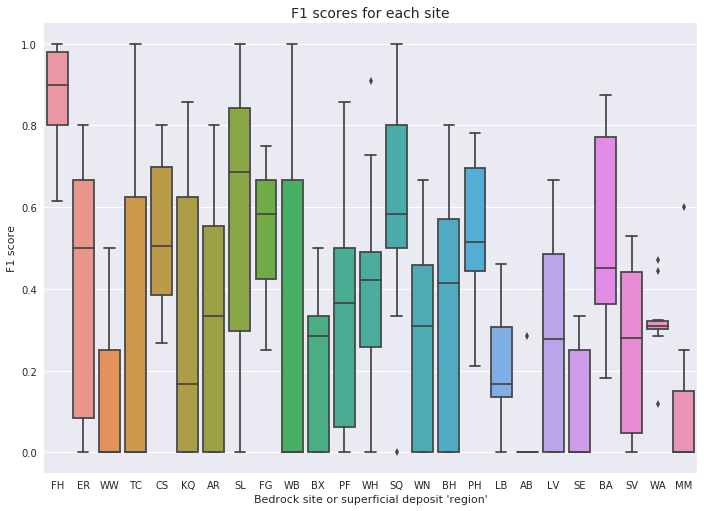

In [99]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Bedrock site or superficial deposit 'region'", fontdict={'fontsize': 11})

#f save_plots == True:
#    fig = plot.get_figure()
#    fig.savefig('site_specific_f1_scores.png')

### Boxplot showing the macro F1 score with weighted averages

Text(0.5,0,'F1-score')

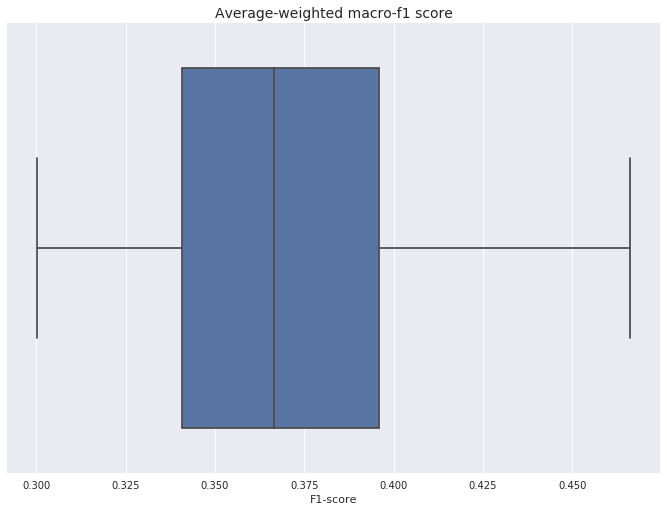

In [100]:
plot = sns.boxplot(macro_f1_scores)
plot.set_title('Average-weighted macro-f1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

#if save_plots == True:
#    fig = plot.get_figure()
#    fig.savefig('macro_f1_scores.png')

### Boxplot showing accuracy scores

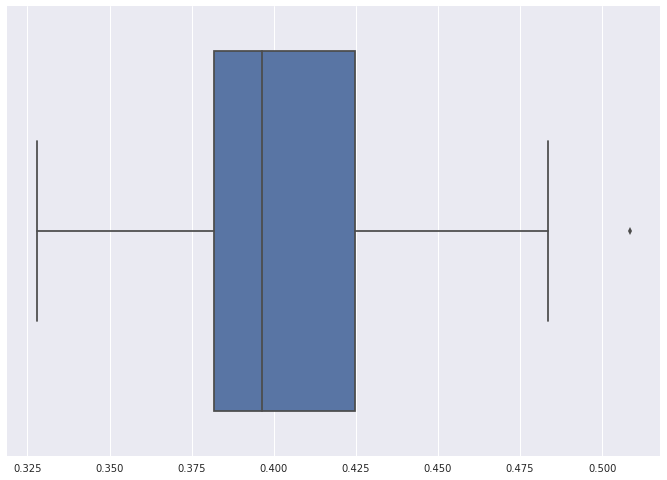

In [101]:
sns.boxplot(accuracy_scores)